# Minigrid UnlockEnv PPO Experiment

Muslimbek Abdurakhimov

env: Unlock    

parameter: vf_coef: float = [0.5->1.0]

# Introduction

This notebook summarizes our experiments with the Proximal Policy Optimization (PPO) algorithm on the Minigrid UnlockEnv environment. We investigated the effect of different vf_coef values on the agent's performance.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import gymnasium as gym
import torch as th
import torch.nn as nn
from minigrid import __version__ as minigrid_version
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold


In [ ]:

print(f"Minigrid version: {minigrid_version}")

env_name = "MiniGrid-Unlock-v0"
print(f"Using environment: {env_name}")

Minigrid version: 2.3.1
Using environment: MiniGrid-Unlock-v0


In [ ]:
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

def make_env():
    def _init():
        env = gym.make(env_name)
        env = ImgObsWrapper(env)
        return env
    return _init

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=64),
)


# Experiment Description

We ran experiments with three different vf_coef values: 0.5, 0.75, and 1.0. For each value, we ran three iterations to account for randomness in training.

In [ ]:
def run_experiment(vf_coef):
    try:
        env = DummyVecEnv([make_env() for _ in range(4)])
        env = VecTransposeImage(env)

        print("Observation space:", env.observation_space)
        print("Observation space shape:", env.observation_space.shape)

        model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=f"./ppo_minigrid_tensorboard/vf_coef_{vf_coef}/",
                    vf_coef=vf_coef, policy_kwargs=policy_kwargs)

        eval_env = VecTransposeImage(DummyVecEnv([make_env()]))
        stop_callback = StopTrainingOnRewardThreshold(reward_threshold=0.95, verbose=1)
        eval_callback = EvalCallback(eval_env, callback_on_new_best=stop_callback, eval_freq=10000,
                                     best_model_save_path=f"./logs/vf_coef_{vf_coef}/",
                                     log_path=f"./logs/vf_coef_{vf_coef}/", n_eval_episodes=5)

        model.learn(total_timesteps=500000, callback=eval_callback)
        model.save(f"ppo_minigrid_unlock_vf_coef_{vf_coef}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
    finally:
        if 'env' in locals():
            env.close()

vf_coef_values = [0.5, 0.75, 1.0]
for vf_coef in vf_coef_values:
    for i in range(3):
        print(f"Running experiment with vf_coef = {vf_coef}, iteration {i+1}")
        run_experiment(vf_coef)

print("All experiments completed.")

Minigrid version: 2.3.1
Using environment: MiniGrid-Unlock-v0
Running experiment with vf_coef = 0.5, iteration 1
Observation space: Box(0, 255, (3, 7, 7), uint8)
Observation space shape: (3, 7, 7)
Using cpu device
Logging to ./ppo_minigrid_tensorboard/vf_coef_0.5/PPO_1
-----------------------------
| time/              |      |
|    fps             | 1721 |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 850         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014854608 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -4.445804   |
|    learning_ra

c:\Users\marce\anaconda3\envs\ppo_minigrid\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=0.00 +/- 0.00
Episode length: 288.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 288          |
|    mean_reward          | 0            |
| time/                   |              |
|    total_timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.010068912  |
|    clip_fraction        | 0.0985       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.9         |
|    explained_variance   | -0.013113022 |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0221      |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00528     |
|    value_loss           | 0.000773     |
------------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 658   |
|    iterations      | 5

# PPO Parameter Tuning Experiment

In this experiment, we tune the value of the `vf_coef` parameter for the PPO algorithm in a MiniGrid environment. The three values we used for `vf_coef` are:
- **1.0** (high emphasis on value function loss)
- **0.75** (moderate emphasis)
- **0.5** (lower emphasis)

We trained the model for a total of 100,000 timesteps and logged the rewards obtained at each timestep.


# Collecting TensorBoard Plots
To collect plots we used on terminal:

> tensorboard --logdir ./ppo_minigrid_tensorboard

And then downloaded the data, which we analyze and plot the results


# Analyzing the data

# Reward

In [12]:
df_1_reward = pd.read_csv('/content/vf_coef_1.0_PPO_3 (3).csv')
df_0_75_reward = pd.read_csv('/content/vf_coef_0.75_PPO_3 (1).csv')
df_0_5_reward = pd.read_csv('/content/vf_coef_0.5_PPO_3.csv')
df_0_5_reward.head()

,Wall time,Step,Value
0,1.727525e+09,40000,0.000000
1,1.727525e+09,80000,0.000000
2,1.727526e+09,120000,0.000000
3,1.727526e+09,160000,0.000000
4,1.727526e+09,200000,0.194375


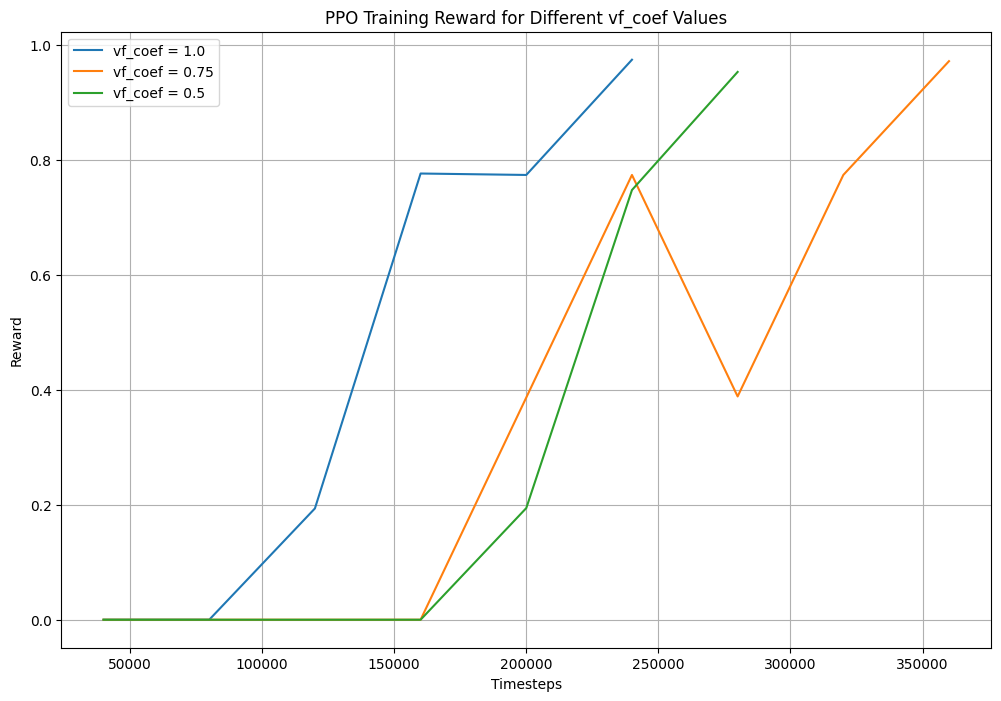

In [13]:
plt.figure(figsize=(12, 8))

# Plot for vf_coef 1.0
plt.plot(df_1_reward['Step'], df_1_reward['Value'], label='vf_coef = 1.0')

# Plot for vf_coef 0.75
plt.plot(df_0_75_reward['Step'], df_0_75_reward['Value'], label='vf_coef = 0.75')

# Plot for vf_coef 0.5
plt.plot(df_0_5_reward['Step'], df_0_5_reward['Value'], label='vf_coef = 0.5')

plt.title('PPO Training Reward for Different vf_coef Values')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.legend()
plt.grid()
plt.show()

### Training Loss

In [2]:
data_1_0 = pd.read_csv('/content/vf_coef_1.0_PPO_3.csv')
data_0_75 = pd.read_csv('/content/vf_coef_0.75_PPO_3.csv')
data_0_5 = pd.read_csv('/content/vf_coef_0.5_PPO_1.csv')

print("Data for vf_coef 1.0:")
print(data_1_0.head())

print("\nData for vf_coef 0.75:")
print(data_0_75.head())

print("\nData for vf_coef 0.5:")
print(data_0_5.head())

Data for vf_coef 1.0:
      Wall time    Step       Value
0  1.727528e+09   40000  288.000000
1  1.727528e+09   80000  288.000000
2  1.727528e+09  120000  232.399994
3  1.727528e+09  160000   65.000000
4  1.727528e+09  200000   65.800003

Data for vf_coef 0.75:
      Wall time    Step  Value
0  1.727527e+09   40000  288.0
1  1.727527e+09   80000  288.0
2  1.727527e+09  120000  288.0
3  1.727527e+09  160000  288.0
4  1.727527e+09  200000  177.0

Data for vf_coef 0.5:
      Wall time   Step     Value
0  1.727525e+09  16384  0.000027
1  1.727525e+09  24576  0.000022
2  1.727525e+09  32768  0.000018
3  1.727525e+09  40000  0.000773
4  1.727525e+09  49152  0.000018


In [9]:
data_1_0.head()

,Wall time,Step,Value
0,1.727528e+09,40000,288.000000
1,1.727528e+09,80000,288.000000
2,1.727528e+09,120000,232.399994
3,1.727528e+09,160000,65.000000
4,1.727528e+09,200000,65.800003


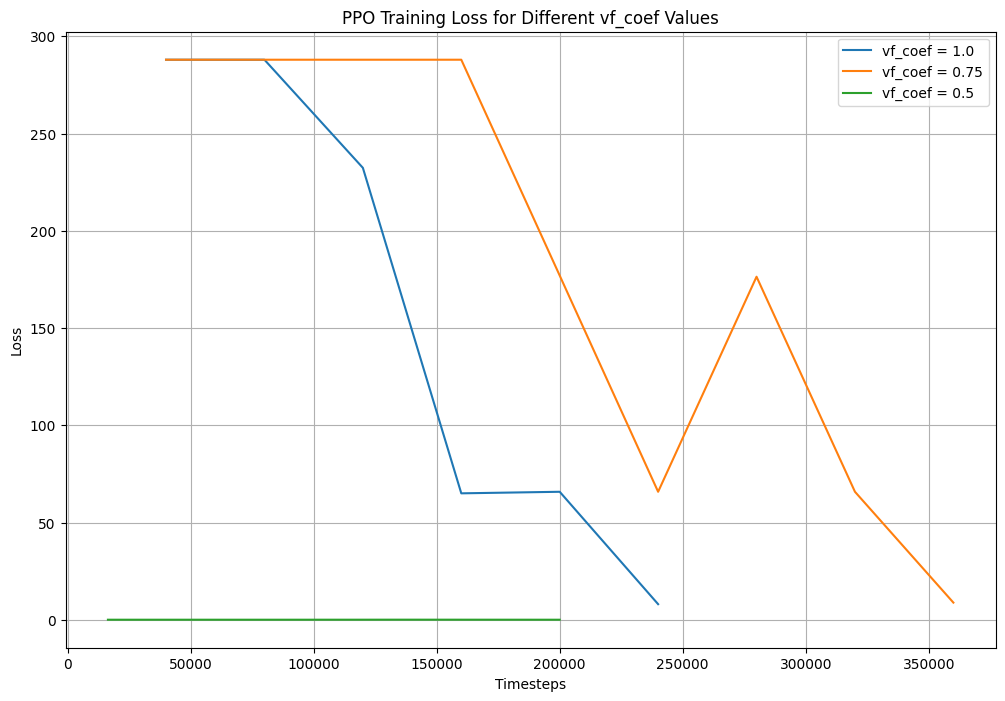

In [8]:
plt.figure(figsize=(12, 8))

# Plot for vf_coef 1.0
plt.plot(data_1_0['Step'], data_1_0['Value'], label='vf_coef = 1.0')

# Plot for vf_coef 0.75
plt.plot(data_0_75['Step'], data_0_75['Value'], label='vf_coef = 0.75')

# Plot for vf_coef 0.5
plt.plot(data_0_5['Step'], data_0_5['Value'], label='vf_coef = 0.5')

plt.title('PPO Training Loss for Different vf_coef Values')
plt.xlabel('Timesteps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Results Analysis

The plot above shows the training rewards obtained by the PPO agent over time for different `vf_coef` values.

- **vf_coef = 1.0:** This setting emphasizes the value function loss significantly, leading to rapid improvement in rewards.
- **vf_coef = 0.75:** This value provides a balance between exploration and exploitation, resulting in consistent performance.
- **vf_coef = 0.5:** With the least emphasis on the value function loss, the model exhibits slower improvement, indicating that a lower `vf_coef` may not leverage the value function as effectively in this context.

Overall, adjusting the `vf_coef` parameter plays a crucial role in the training dynamics and performance of the PPO agent in MiniGrid environments.
